This notebook demonstrates how we compute the auc, how to calculate the auc/accuracy gain, and how to plot the roc curves of the EM/Power and multimodal models

# Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # surpress warning and info messages
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L2 as l2
from tensorflow.keras.layers import Dense, Layer, Reshape, Flatten, Dot, Softmax, concatenate
from sklearn.metrics import roc_curve,roc_auc_score
import tensorflow as tf
from os.path import *
import pandas as pd
import numpy as np
import argparse
import json
import glob
import sys

sys.path.append('../Model')
sys.path.append('../DataGenerators')
from base_model import build_transformer
from fusion_data_generator import FusionDataGenerator
from data_generator import DataGenerator

# Function Definitions

In [2]:
# our way to compute auc is a little different than the classic:
def compute_auc(test_probas, attack_probas):

    # max confidence of each test sample
    test_max_conf = np.max(test_probas, axis=1)
    
    # max condifdence in each attack sample
    attacks_max_conf = np.max(attack_probas, axis=1)
    
    # the probability of an attack is 1- (the probability of the max class), now this is binary
    new_attacks_probas = 1 - attacks_max_conf
    new_test_probas = 1 - test_max_conf

    y_pred = np.concatenate((new_test_probas, new_attacks_probas))
    y_true = ([0] * len(new_test_probas)) + ([1] * len(new_attacks_probas))

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return fpr, tpr, auc


class CrossAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(CrossAttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(CrossAttentionLayer, self).build(input_shape)
        
    def call(self, inputs):
        embedding_1, embedding_2 = inputs
        
        # Calculate attention weights
        attention_weights = Dot(axes=-1, normalize=True)([embedding_2, embedding_1])
        attention_weights = Softmax()(attention_weights)
        
        # Apply attention weights to embedding_1
        attended_embedding_1 = Dot(axes=1)([attention_weights, embedding_1])
        
        return attended_embedding_1
    
    def compute_output_shape(self, input_shape):
        return input_shape[0]

def get_running_times(root):
    with open(f'{root}POWER/metadata.json', 'r') as f: # the running time of both datasets are identical
        metadata = json.load(f)
        max =  metadata['max_running_time']
        min =  metadata['min_running_time']
        return max,min

# builds a dataframe with the path and class of each sample for the multimodal
def get_samples_multimodal(root, attacks=False):
    samples_df = pd.DataFrame(columns=["EM_path", "POWER_path","class", "numeric_class"])
    power_samples_path = []
    em_samples_path = []
    samples_class = []

    for filename in glob.iglob(f'{root}**/*.npy', recursive=True):
        clas = basename(dirname(filename)) # folder name is the name of the class
        power_sample_path = filename
        power_samples_path.append(power_sample_path)
        em_samples_path.append(power_sample_path.replace("POWER","EM"))
        samples_class.append(clas)

    samples_df["POWER_path"] = power_samples_path
    samples_df["EM_path"] = em_samples_path
    samples_df["class"] = samples_class

    unique_classes = samples_df["class"].copy().drop_duplicates().sort_values(ignore_index=True)
    samples_df['numeric_class'] = samples_df['class'].apply(lambda class_name: unique_classes[unique_classes == class_name].index[0])
    
    return samples_df, unique_classes

def get_multimodal(power_shape, em_shape, n_classes):
    power_inputs, power_embeddings = build_transformer(power_shape)
    em_inputs, em_embeddings = build_transformer(em_shape)

    power_embeddings = Reshape(target_shape=(1,128))(power_embeddings)
    em_embeddings = Reshape(target_shape=(1,128))(em_embeddings)
    attended1 = CrossAttentionLayer()([power_embeddings, em_embeddings])
    attended2 = CrossAttentionLayer()([em_embeddings, power_embeddings])
    fused_embeddings = concatenate([attended1,attended2])
    flat = Flatten()(fused_embeddings)
    final_output = Dense(n_classes, activation='sigmoid', kernel_regularizer=l2(0.0005))(flat)
    
    model = tf.keras.Model([power_inputs, em_inputs], final_output)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=['accuracy'])
    # print(model.summary())
    return model

# builds a dataframe with the path and class of each sample for the unimodals
def get_samples_unimodal(root):
    samples_df = pd.DataFrame(columns=["path", "class", "numeric_class"])
    samples_path = []
    samples_class = []

    for filename in glob.iglob(root + '**/*.npy', recursive=True):
        clas = basename(dirname(filename)) # folder name is the name of the class
        samples_path.append(filename)
        samples_class.append(clas)

    samples_df["path"] = samples_path
    samples_df["class"] = samples_class

    unique_classes = samples_df["class"].copy().drop_duplicates().sort_values(ignore_index=True)
    samples_df['numeric_class'] = samples_df['class'].apply(lambda class_name: unique_classes[unique_classes == class_name].index[0])

    return samples_df, unique_classes

def get_unimodal(input_shape, n_classes):
    inputs, intermediate_outputs = build_transformer(input_shape)
    probs = Dense(n_classes, activation='sigmoid', kernel_regularizer=l2(0.0005))(intermediate_outputs)
    model =  tf.keras.Model(inputs, probs)
    
    model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
    # print(model.summary())
    return model

# Test the EM model

In [3]:
dataset_path = "../testset/"
n_classes = 24
max_running_time, min_running_time = get_running_times(dataset_path)
em_noise_strength = 5

em_samples_df, _ = get_samples_unimodal(f'{dataset_path}EM/') # benign samples
em_attacks_samples_df, classes_df = get_samples_unimodal(f'{dataset_path}EM/.attacks/') # attack samples

# create generators
em_test_generator = DataGenerator(em_samples_df , n_classes=n_classes, max_running_time=max_running_time, min_running_time=min_running_time, win_size=3, sampling_rate=56000000, sigma=em_noise_strength)
em_attacks_generator = DataGenerator(em_attacks_samples_df , n_classes=len(classes_df.index), max_running_time=max_running_time, min_running_time=min_running_time, win_size=3, sampling_rate=56000000, sigma=em_noise_strength)
em_input_shape = em_test_generator.get_shape()

# load model
em_model = get_unimodal(em_input_shape, n_classes)
em_model.load_weights(f"../trained_models/single_channel/em_noise_{em_noise_strength}.hdf5")

# test
em_test_probas = em_model.predict(em_test_generator, verbose=1)
em_attacks_probas = em_model.predict(em_attacks_generator, verbose=1)

# compute auc/accuracy
fpr_em, tpr_em, auc_em = compute_auc(em_test_probas, em_attacks_probas)

y_pred_em = np.argmax(em_test_probas, axis=1)
y_true_em = em_test_generator.y_true
accuracy_em = sum(y_pred_em == y_true_em) / len(y_true_em)

900/900 [==============================] - 33s 37ms/step


# Test the Power model

In [4]:
dataset_path = "../testset/"
n_classes = 24
max_running_time, min_running_time = get_running_times(dataset_path)
power_noise_strength = 13

power_samples_df, _ = get_samples_unimodal(f'{dataset_path}POWER/') # benign samples
power_attacks_samples_df, classes_df = get_samples_unimodal(f'{dataset_path}POWER/.attacks/') # attack samples

# create generators
power_test_generator = DataGenerator(power_samples_df , n_classes=n_classes, max_running_time=max_running_time, min_running_time=min_running_time, win_size=30, sampling_rate=1000000000, sigma=power_noise_strength)
power_attacks_generator = DataGenerator(power_attacks_samples_df , n_classes=len(classes_df.index), max_running_time=max_running_time, min_running_time=min_running_time, win_size=30, sampling_rate=1000000000, sigma=power_noise_strength)
power_input_shape = power_test_generator.get_shape()

# load model
power_model = get_unimodal(power_input_shape, n_classes)
power_model.load_weights(f"../trained_models/single_channel/power_noise_{power_noise_strength}.hdf5")

# test
power_test_probas = power_model.predict(power_test_generator, verbose=1)
power_attacks_probas = power_model.predict(power_attacks_generator, verbose=1)

# compute auc/accuracy
fpr_power, tpr_power, auc_power = compute_auc(power_test_probas, power_attacks_probas)

y_pred_power = np.argmax(power_test_probas, axis=1)
y_true_power = power_test_generator.y_true
accuracy_power = sum(y_pred_power == y_true_power) / len(y_true_power)

900/900 [==============================] - 50s 56ms/step


# Test the multimodal

In [5]:
dataset_path = "../testset/"
n_classes = 24
max_running_time, min_running_time = get_running_times(dataset_path)

multimodal_samples_df, _ = get_samples_multimodal(f'{dataset_path}/POWER/')
multimodal_attacks_samples_df, classes_df = get_samples_multimodal(f'{dataset_path}/POWER/.attacks/')

# create generators
multimodal_test_generator = FusionDataGenerator(multimodal_samples_df, mode='intermediate', n_classes=24, max_running_time=max_running_time, min_running_time=min_running_time, sampling_rate_power=1000000000, sampling_rate_em=56000000, overlapping_percentage=0.6, em_noise_sigma=em_noise_strength, power_noise_sigma=power_noise_strength)
multimodal_attacks_generator = FusionDataGenerator(multimodal_attacks_samples_df, mode='intermediate', n_classes=len(classes_df.index), max_running_time=max_running_time, min_running_time=min_running_time, sampling_rate_power=1000000000, sampling_rate_em=56000000, overlapping_percentage=0.6, em_noise_sigma=em_noise_strength, power_noise_sigma=power_noise_strength)
power_shape, em_shape = multimodal_test_generator.get_shape()

# load model
multimodal_model = get_multimodal(power_shape, em_shape, n_classes)
multimodal_model.load_weights(f"../trained_models/intermediate_integration/em_noise_{em_noise_strength}_power_noise_{power_noise_strength}.hdf5")

# test
multimodal_test_probas = multimodal_model.predict(multimodal_test_generator, verbose=1)  
multimodal_attacks_probas = multimodal_model.predict(multimodal_attacks_generator, verbose=1)

# compute auc/accuracy
fpr_multimodal, tpr_multimodal, auc_multimodal = compute_auc(multimodal_test_probas, multimodal_attacks_probas)

y_pred_multimodal = np.argmax(multimodal_test_probas, axis=1)
y_true_multimodal = multimodal_test_generator.y_true
accuracy_multimodal = sum(y_pred_multimodal == y_true_multimodal) / len(y_true_multimodal)

900/900 [==============================] - 70s 77ms/step


# Accuracy/AUC gain

EM noise:5, POWER noise:13, AUC gain:0.0925234953703703, Accuracy Gain:0.17645833333333338


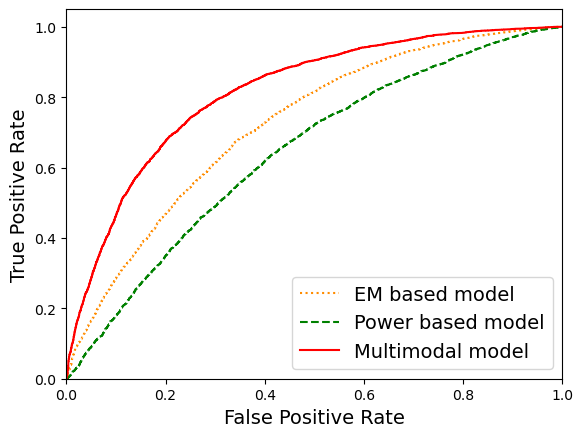

In [6]:
auc_gain = (auc_multimodal - max(auc_em, auc_power))
accuracy_gain = (accuracy_multimodal - max(accuracy_em, accuracy_power))
print(f"EM noise:{em_noise_strength}, POWER noise:{power_noise_strength}, AUC gain:{auc_gain}, Accuracy Gain:{accuracy_gain}")

plt.figure()
plt.plot(fpr_em, tpr_em, color='darkorange', linestyle='dotted', label=f'EM based model')
plt.plot(fpr_power, tpr_power, color='green', linestyle='dashed', label=f'Power based model')
plt.plot(fpr_multimodal, tpr_multimodal, color='red', linestyle='solid', label=f'Multimodal model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=14);